# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

/tmp/ipykernel_41499/866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


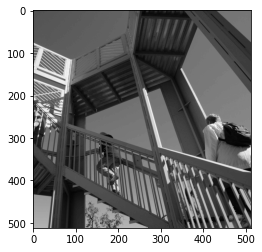

In [2]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

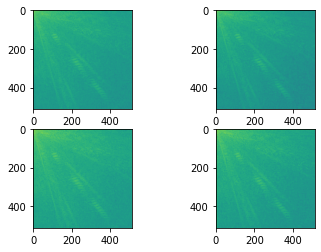

In [3]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

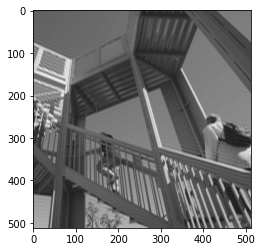

In [4]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

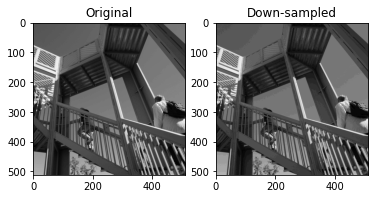

In [5]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

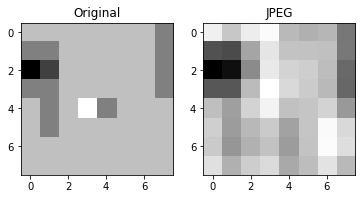

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [6]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

## Sarcina 1

In [7]:
def compresie_JPEG(X):
    Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]
    X_jpeg = np.zeros(X.shape)
    Y = np.zeros(X.shape)
    Y_jpeg = np.zeros(X.shape)
    
    for linie in range (1, X.shape[0] // 8 + 1):
        for coloana in range (1, X.shape[1] // 8 + 1):
            x = X[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8]
            y = dctn(x)
            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            
            # Decoding
            x_jpeg = idctn(y_jpeg)
            X_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = x_jpeg
            Y[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y
            Y_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y_jpeg
            
    # Results
    Y_nnz = np.count_nonzero(Y)
    Y_jpeg_nnz = np.count_nonzero(Y_jpeg)
    return X_jpeg, Y_nnz, Y_jpeg_nnz


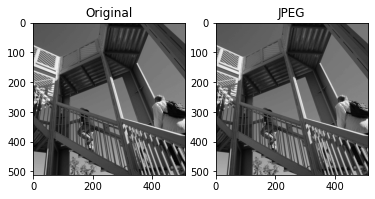

Componente în frecvență:250378
Componente în frecvență după cuantizare: 125029


In [8]:
X_jpeg, Y_nnz, Y_jpeg_nnz = compresie_JPEG(X)

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(Y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(Y_jpeg_nnz))

## Sarcina 2

In [12]:
def compresie_JPEG_color(X):
    Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]
    Q_jpeg = np.array(Q_jpeg)
    Q_jpeg = Q_jpeg[:, :, np.newaxis]
    Q_jpeg = np.repeat(Q_jpeg, 3, axis=2)

    X = cv2.cvtColor(X, cv2.COLOR_RGB2YCrCb)
    
    X_jpeg = np.zeros(X.shape)
    Y = np.zeros(X.shape)
    Y_jpeg = np.zeros(X.shape)
    
    for linie in range (1, X.shape[0] // 8 + 1):
        for coloana in range (1, X.shape[1] // 8 + 1):
            x = X[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8]
            y = dctn(x)
            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            
            # Decoding
            x_jpeg = idctn(y_jpeg)
            X_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = x_jpeg
            Y[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y
            Y_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y_jpeg

    X_jpeg = X_jpeg.astype('uint8')

    X_rgb_jpeg = cv2.cvtColor(X_jpeg, cv2.COLOR_YCrCb2RGB)

    # Results
    Y_nnz = np.count_nonzero(Y)
    Y_jpeg_nnz = np.count_nonzero(Y_jpeg)
    return X_rgb_jpeg, Y_nnz, Y_jpeg_nnz



/tmp/ipykernel_41499/440261368.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X_color = misc.face().copy()


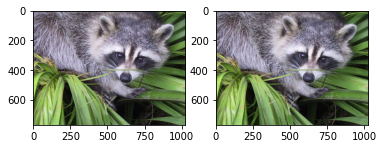

Componente în frecvență:2323732
Componente în frecvență după cuantizare: 736025


In [13]:
X_color = misc.face().copy()

X_rgb_jpeg, Y_nnz_color, Y_jpeg_nnz_color = compresie_JPEG_color(X_color)

plt.subplot(121).imshow(X_color)
plt.subplot(122).imshow(X_rgb_jpeg)

plt.show()

print('Componente în frecvență:' + str(Y_nnz_color) + 
      '\nComponente în frecvență după cuantizare: ' + str(Y_jpeg_nnz_color))

## Sarcina 3

In [14]:
def compresie_JPEG_color_mse(X, mse):
    #un fel de cautare binara (nu urca liniar asa ca am hardcodat niste praguri):
    X_ycrcb = cv2.cvtColor(X, cv2.COLOR_RGB2YCrCb)
    mse_actual = -1
    Q_factor = 1
    while np.round(mse_actual) != mse:
        Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]
        Q_jpeg = np.array(Q_jpeg)
        Q_jpeg = np.round(Q_jpeg / Q_factor)
        #print(Q_jpeg)
        Q_jpeg = Q_jpeg[:, :, np.newaxis]
        Q_jpeg = np.repeat(Q_jpeg, 3, axis=2)
    
        X_jpeg = np.zeros(X_ycrcb.shape)
        Y = np.zeros(X_ycrcb.shape)
        Y_jpeg = np.zeros(X_ycrcb.shape)
        for linie in range (1, X_ycrcb.shape[0] // 8 + 1):
            for coloana in range (1, X_ycrcb.shape[1] // 8 + 1):
                x = X_ycrcb[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8]
                y = dctn(x)
                y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
                
                # Decoding
                x_jpeg = idctn(y_jpeg)
                X_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = x_jpeg
                Y[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y
                Y_jpeg[(linie-1) * 8 : linie*8, (coloana-1) * 8 : coloana * 8] = y_jpeg
        X_ycrcb_jpeg = X_jpeg.astype('uint8')
        X_rgb_jpeg = cv2.cvtColor(X_ycrcb_jpeg, cv2.COLOR_YCrCb2RGB)
        
        mse_actual = np.mean((X - X_rgb_jpeg) ** 2)
        if np.round(mse_actual) < mse:
            semn = -1
        elif np.round(mse_actual) > mse:
            semn = 1
        else:
            break
        if Q_factor >= 0.2 and Q_factor < 2:
            Q_factor = Q_factor + semn * 0.1
        elif Q_factor >= 0.06 and Q_factor < 0.2:
            Q_factor = Q_factor + semn * 0.01
        elif Q_factor >= 0.015 and Q_factor < 0.06:
            Q_factor = Q_factor + semn * 0.001
        elif Q_factor >= 0.002 and Q_factor < 0.015:
            Q_factor = Q_factor + semn * 0.004
        else:
            print("mse nevalid")
            break

        if Q_factor == 0:
            Q_factor = Q_factor + semn * 0.1
        print(mse_actual, Q_factor)
    
    # Results
    Y_nnz = np.count_nonzero(Y)
    Y_jpeg_nnz = np.count_nonzero(Y_jpeg)
    return X_rgb_jpeg, Y_nnz, Y_jpeg_nnz

Introduceti o valoare pentru MSE intre 2 si 20:  2


/tmp/ipykernel_41499/1638927294.py:3: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X_color = misc.face().copy()


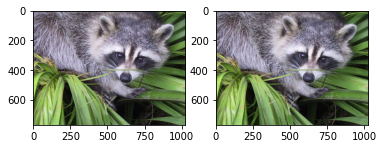

Componente în frecvență:2323732
Componente în frecvență după cuantizare: 736025
Mean Square Error (MSE): 1.9242880079481337, which is approximately 2.0


In [16]:
mse = int(input("Introduceti o valoare pentru MSE intre 2 si 20: "))

X_color = misc.face().copy()

X_rgb_jpeg, Y_nnz_color, Y_jpeg_nnz_color = compresie_JPEG_color_mse(X_color, mse)

plt.subplot(121).imshow(X_color)
plt.subplot(122).imshow(X_rgb_jpeg)

plt.show()

print('Componente în frecvență:' + str(Y_nnz_color) + 
      '\nComponente în frecvență după cuantizare: ' + str(Y_jpeg_nnz_color))

mse = np.mean((X_color - X_rgb_jpeg) ** 2)
print(f"Mean Square Error (MSE): {mse}, which is approximately {np.round(mse)}")

## Sarcina 4

In [20]:
from tqdm import tqdm

video_path = 'shrek.mp4'

video = cv2.VideoCapture(video_path)

frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

initial_video = []
new_video = []

for i in tqdm(range(frame_count)):
    ret, frame = video.read()
    if not ret:
            break
    frame_new, y1, y2 = compresie_JPEG_color(frame)
    initial_video.append(frame)
    new_video.append(frame_new)

for frame in initial_video:
    cv2.imshow('Initial video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
         break

for frame_compressed in new_video:
    cv2.imshow('JPG compressed', frame_compressed)
    if cv2.waitKey(25) & 0xFF == ord('q'):
         break

video.release()
cv2.destroyAllWindows()

# for i in range (frame_count):
    



100%|███████████████████████████████████████████| 77/77 [00:30<00:00,  2.51it/s]
